In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# New Section

In [11]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [12]:
worksheet = gc.open('Ingredients').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()




ingredientdf = pd.DataFrame.from_records(rows,columns = rows[0])
ingredientdf = ingredientdf[1:]

In [13]:
ingredientdf.head()

,Name,Calories,Protein,Serving Size
1,Peanut Butter,90,4,100
2,Oats,180,7.5,100
3,Milk,130,9,100
4,Banana,95,1,100
5,Apple,90,1,100


In [14]:
import json

worksheet = gc.open('Recipes').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()


recipedf = pd.DataFrame.from_records(rows,columns = rows[0])
recipedf = recipedf[1:]


In [15]:
class Ingredient:
    def __init__(self, name, calories, protein, serving_size = 100):
        self.name = name
        self.calories = calories/serving_size*100
        self.protein = protein/serving_size*100
        self.serving_size = serving_size

    def __init__(self,name):
        self.name = name
        row = ingredientdf.loc[ingredientdf["Name"]==name]
        self.calories = float(row["Calories"].values[0])
        self.protein = float(row["Protein"].values[0])
        self.serving_size = float(row["Serving Size"].values[0])


class Food:
  #if you deon't include a list of ingredients it will start as an empty list
  #otherwise you can include a list of pairs (ingredient,amount(g))
    def __init__(self, name):
        self.name = name
        self.ingredients = []


    def get_existing_recipe(self):
        recipe = recipedf.loc[recipedf["Name"]==self.name]["Ingredients"].values
        if recipe.size == 0:
            print("no recipe named " + self.name + ".")
        else:
            recipe_json = json.loads(recipe[0])
            for ingredient in recipe_json:
                ingredient_obj = Ingredient(ingredient["name"])
                self.ingredients.append((ingredient_obj,int(ingredient["amount_g"])))

    def add_ingredient(self, ingredient, amount):
        if isinstance(ingredient, Ingredient):
            self.ingredients.append((ingredient,amount))
        else:
            raise ValueError("Ingredient must be an instance of the Ingredient class")

    def save_recipe(self):
        global recipedf
        json_string = json.dumps([{"name":ob.name,"amount_g":amt} for ob,amt in self.ingredients])
        recipe_index = recipedf.index[recipedf["Name"] == self.name].tolist()
        if recipe_index:
            recipedf = recipedf.drop(recipe_index[0])
        recipedf = pd.concat([recipedf,pd.DataFrame({"Name":self.name,"Ingredients":json_string},index=[0])],ignore_index=True)
        worksheet.update([["Name","Ingredients"]] + recipedf.values.tolist())

    def total_calories(self):
        return sum([ingredient.calories*amount/100 for ingredient,amount in self.ingredients])

    def total_protein(self):
        return sum([ingredient.protein*amount/100 for ingredient,amount in self.ingredients])



# Example usage:
goatmeal = Food("GOATmeal")
goatmeal.get_existing_recipe()
goatmeal.save_recipe()

protein_shake = Food("protein shake")
protein_shake.add_ingredient(Ingredient("Peanut Butter"),100)
protein_shake.add_ingredient(Ingredient("Banana"),100)
protein_shake.add_ingredient(Ingredient("Milk"),100)
protein_shake.save_recipe()

display(recipedf)
# Calculate total calories and protein in the goatmeal
total_calories = goatmeal.total_calories() + protein_shake.total_calories()
total_protein = goatmeal.total_protein() + protein_shake.total_protein()

print(f"{goatmeal.name}")
print(f"Total Calories: {total_calories} kcal")
print(f"Total Protein: {total_protein} grams")

,Name,Ingredients
0,asd,"[{""name"": ""Oats"", ""amount_g"": 11.0}, {""name"": ..."
1,GOATmeal,"[{""name"": ""Oats"", ""amount_g"": 100}, {""name"": ""..."
2,protein shake,"[{""name"": ""Peanut Butter"", ""amount_g"": 100}, {..."


GOATmeal
Total Calories: 1180.0 kcal
Total Protein: 102.5 grams


In [16]:
import ipywidgets as ipw

recipe_name_box = ipw.Text(description = "Recipe Name")

ingredient_box = ipw.Combobox( #Maybe change this to dropdown?
    placeholder='Choose an Ingredient',
    options=ingredientdf["Name"].tolist(),
    description='Ingredient',
    ensure_option=True,
    disabled=False
)

ingredient_amount = ipw.FloatText(
    value=0,
    description='Amount',
    disabled=False
)

add_ingredient_button = ipw.Button(description = "Add Ingredient")

save_recipe_button = ipw.Button(description = "Save Recipe")

output = ipw.Output()

new_recipe = None

def on_button_clicked(b):
    global new_recipe
    if recipe_name_box.value == "":
        with output:
            print("Please enter a name for your recipe")
    else:
        if not new_recipe:
         new_recipe = Food(recipe_name_box.value)
        if ingredient_box.value == "":
            with output:
                print("Please choose an ingredient")
        elif ingredient_amount.value <= 0:
            with output:
                print("Add more than 0g")
        else:
            #check if ingredient is already in the recipe before adding
            new_recipe.add_ingredient(Ingredient(ingredient_box.value),ingredient_amount.value)
            with output:
                print(str(ingredient_amount.value) + 'g of ' + ingredient_box.value)
            ingredient_box.value = ""
            ingredient_amount.value = 0
add_ingredient_button.on_click(on_button_clicked)

def save_recipe(b):
    global new_recipe
    new_recipe.save_recipe()
    output.clear_output()
    with output:
        print("Recipe " + new_recipe.name + " saved with ingredients: ")
        for i,amt in new_recipe.ingredients:
            print(i.name,amt)

save_recipe_button.on_click(save_recipe)

ingredient_adder = ipw.HBox([ingredient_box,ingredient_amount,add_ingredient_button])

display(recipe_name_box,ingredient_adder,output,save_recipe_button) #change the output display to a list that updates instead of lines of text



Text(value='', description='Recipe Name')

Output()

Button(description='Save Recipe', style=ButtonStyle())

In [18]:
ingredient_name_box = ipw.Text(description = "Ingredient")
ingredient_calories = ipw.FloatText(
    description='Calories',
    disabled=False
)
ingredient_protein = ipw.FloatText(
    description='Protein',
    disabled=False
)
ingredient_serving_size = ipw.FloatText(
    description='Serving Size',
    disabled=False
)
create_ingredient_button = ipw.Button(description = "Create Ingredient")

output2 = ipw.Output()

def create_ingredient(b):
    global ingredientdf
    if ingredient_name_box.value == "":
        with output2:
            print("Please enter a name for your ingredient")
    else:
        ingredientdf = pd.concat([ingredientdf,pd.DataFrame({"Name":ingredient_name_box.value,"Calories":ingredient_calories.value,"Protein":ingredient_protein.value,"Serving Size":ingredient_serving_size.value},index=[0])],ignore_index=True)
        worksheet = gc.open('Ingredients').sheet1
        worksheet.update([ingredientdf.columns.tolist()] + ingredientdf.values.tolist()) # maybe don't do this everytime? only update sheet from df occaisionally?
        with output2:
            print("Created " + ingredient_name_box.value + ' ' + str(ingredient_calories.value) + 'g cals, ' + str(ingredient_protein.value) + 'g protein per ' + str(ingredient_serving_size.value) + ' g')

create_ingredient_button.on_click(create_ingredient)


macros_box = ipw.HBox([ingredient_calories,ingredient_protein,ingredient_serving_size,create_ingredient_button])

display(ingredient_name_box,macros_box,output2)

Text(value='', description='Ingredient')

Output()

no recipe named Oats_v3.
no recipe named pb condiment.
no recipe named pure protein.
no recipe named pure protein.


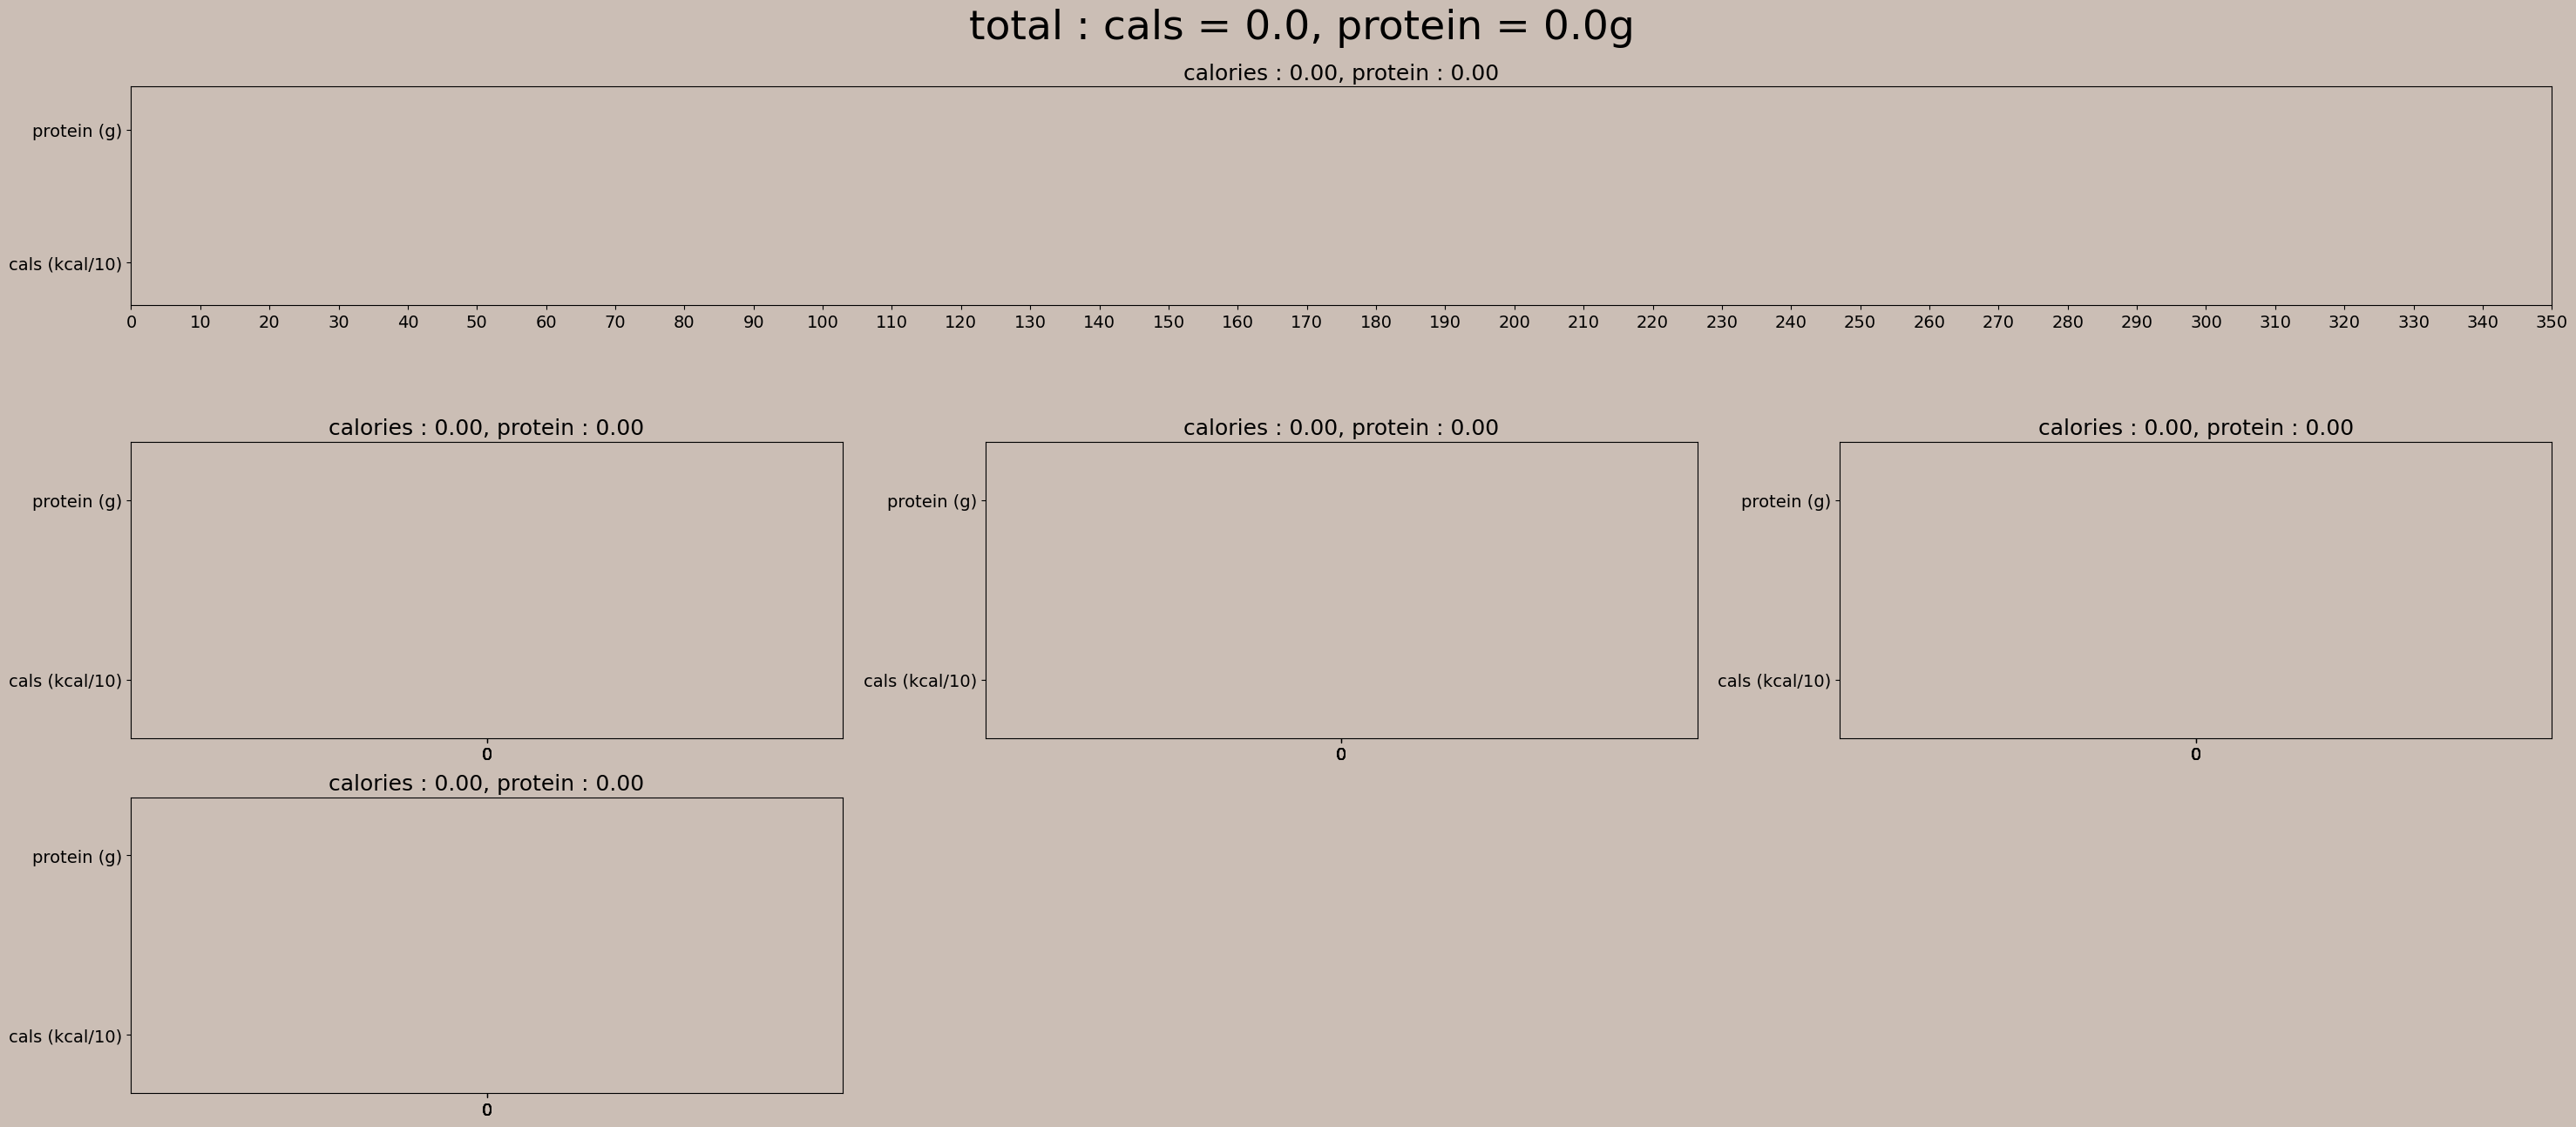

In [10]:
#daily = [oats_v3, pb_condiment, pure_protein, pure_protein]
daily = [Food("Oats_v3"),Food("pb condiment"),Food("pure protein"),Food("pure protein")]# create these in recipe df
for food in daily:
    food.get_existing_recipe()
totals = np.zeros(2)

plt.figure(figsize=(23.9*1.5, 10*1.5),facecolor="#cbbeb5")

for idx, val in enumerate(daily):
    plt.subplot(3, 3, 4+idx,facecolor='#cbbeb5')
    plt.barh([0.2,0.8],[val.total_calories()/10,val.total_protein()],0.3,color='#525266')
    plt.title(f'calories : {val.total_calories():.2f}, protein : {val.total_protein():.2f}', fontsize=18)
    plt.xticks(np.linspace(0,val.total_protein()*1.2,5),fontsize=14,)
    plt.yticks([0.2,0.8],['cals (kcal/10)','protein (g)'],fontsize=14)

    totals[0] += val.total_calories()/10
    totals[1] += val.total_protein()

plt.subplot(len(daily), 1, 1,facecolor='#cbbeb5')
plt.barh([0.2,0.8],[totals[0],totals[1]],0.3,color='#423f3b')
plt.title(f'calories : {totals[0]:4.2f}, protein : {totals[1]:.2f}', fontsize=18)
plt.xticks(np.linspace(0,350,36),fontsize=14)
plt.yticks([0.2,0.8],['cals (kcal/10)','protein (g)'],fontsize=14)

plt.suptitle(f'total : cals = {totals[0]*10}, protein = {totals[1]}g', fontsize=34,y=.94)
plt.show()